# Time Series Forecasting with Transformer in PyTorch
This notebook demonstrates how to use a simple Transformer architecture for time series forecasting using PyTorch.

In [1]:
# Import required libraries
import os
from datetime import datetime
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from data_utils import generate_nonstationary_signal
from transformer_model import RecursiveTimeSeriesTransformer

In [2]:
# Hyperparameters
SEQ_LENGTH = 25
NUM_SAMPLES = 1000
BATCH_SIZE = 32
EPOCHS = 4
LR = 0.001
FORECAST_STEPS = 5

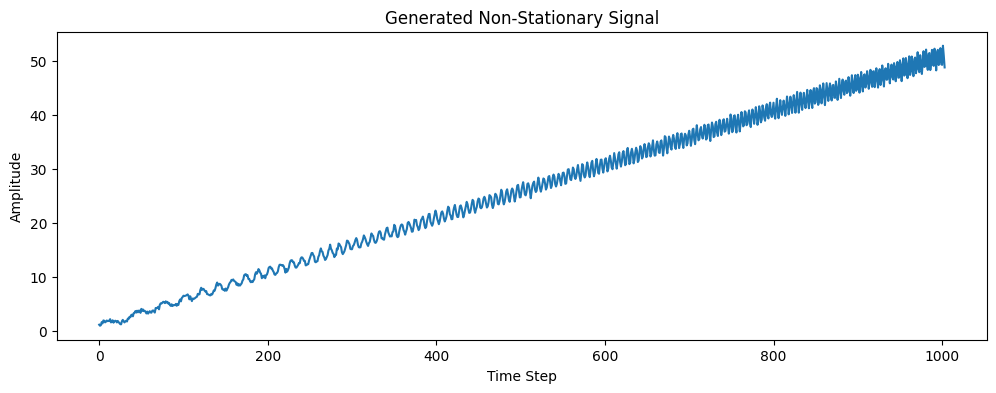

In [3]:
# Generate a single non-stationary signal
signal = generate_nonstationary_signal(NUM_SAMPLES + FORECAST_STEPS - 1)  # shape: (NUM_SAMPLES + FORECAST_STEPS - 1,)

plt.figure(figsize=(12, 4))
plt.plot(signal)
plt.title("Generated Non-Stationary Signal")
plt.xlabel("Time Step")
plt.ylabel("Amplitude")
plt.show()

In [ ]:
X = []
y = []
for i in range(len(signal) - SEQ_LENGTH - FORECAST_STEPS + 1):
    X.append(signal[i:i+SEQ_LENGTH])
    y.append(signal[i+SEQ_LENGTH:i+SEQ_LENGTH+FORECAST_STEPS])

X = np.array(X)
y = np.array(y)

In [5]:
X.shape, y.shape

((973, 26), (973, 6))

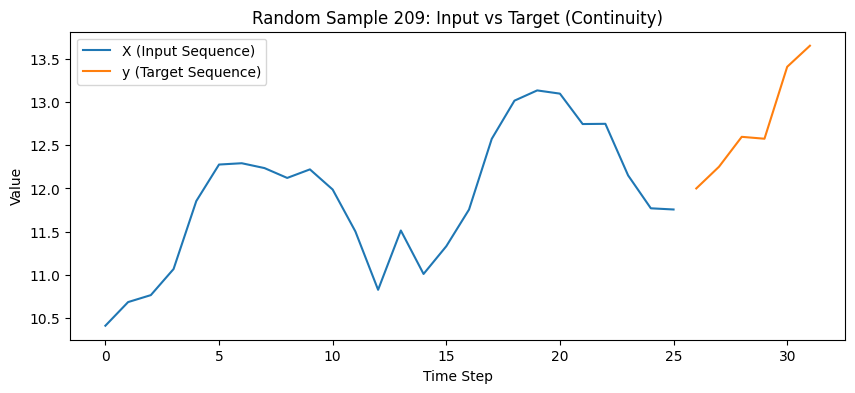

In [6]:
# Plot a random sample from X and y
idx = np.random.randint(len(X))
plt.figure(figsize=(10, 4))
plt.plot(range(X.shape[1]), X[idx], label='X (Input Sequence)')
plt.plot(range(X.shape[1], X.shape[1] + y.shape[1]), y[idx], label='y (Target Sequence)')
plt.title(f'Random Sample {idx}: Input vs Target (Continuity)')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

In [7]:
# LogReturnScaler for time series with integrated StandardScaler
from sklearn.preprocessing import StandardScaler

class LogReturnScaler:
    def __init__(self):
        self.min_ = None
        self.shift_ = None
        self.fitted_ = False
        self.X0_ = None  # Store initial values for inverse transform
        self.scaler_ = StandardScaler()
    def fit(self, X):
        self.min_ = np.min(X)
        self.shift_ = -self.min_ + 1e-6 if self.min_ <= 0 else 0
        self.fitted_ = True
        self.X0_ = X[:, 0]  # Store initial value for each sample
        X_shifted = X + self.shift_
        logret = np.log(X_shifted[..., 1:]) - np.log(X_shifted[..., :-1])
        self.scaler_.fit(logret)
        return self
    def transform(self, X):
        if not self.fitted_:
            raise RuntimeError("LogReturnScaler must be fitted before calling transform.")
        X_shifted = X + self.shift_
        logret = np.log(X_shifted[..., 1:]) - np.log(X_shifted[..., :-1])
        return self.scaler_.transform(logret)
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)
    def inverse_transform(self, X_logret, X0=None):
        if not self.fitted_:
            raise RuntimeError("LogReturnScaler must be fitted before calling inverse_transform.")
        # Inverse StandardScaler
        logret = self.scaler_.inverse_transform(X_logret)
        n_samples = logret.shape[0]
        n_steps = logret.shape[1] + 1
        X_recon = np.zeros((n_samples, n_steps))
        # Use provided X0 or default to self.X0_
        if X0 is not None:
            X_recon[:, 0] = X0
        else:
            X_recon[:, 0] = self.X0_[:n_samples]
        for t in range(1, n_steps):
            X_recon[:, t] = X_recon[:, t-1] * np.exp(logret[:, t-1])
        return X_recon


In [8]:
# PctChangeScaler for time series with integrated StandardScaler
from sklearn.preprocessing import StandardScaler

class PctChangeScaler:
    def __init__(self):
        self.min_ = None
        self.shift_ = None
        self.fitted_ = False
        self.X0_ = None  # Store initial values for inverse transform
        self.scaler_ = StandardScaler()
    def fit(self, X):
        self.min_ = np.min(X)
        self.shift_ = -self.min_ + 1e-6 if self.min_ <= 0 else 0
        self.fitted_ = True
        self.X0_ = X[:, 0]  # Store initial value for each sample
        X_shifted = X + self.shift_
        pct_change = (X_shifted[..., 1:] - X_shifted[..., :-1]) / X_shifted[..., :-1]
        self.scaler_.fit(pct_change)
        return self
    def transform(self, X):
        if not self.fitted_:
            raise RuntimeError("PctChangeScaler must be fitted before calling transform.")
        X_shifted = X + self.shift_
        pct_change = (X_shifted[..., 1:] - X_shifted[..., :-1]) / X_shifted[..., :-1]
        return self.scaler_.transform(pct_change)
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)
    def inverse_transform(self, X_pct, X0=None):
        if not self.fitted_:
            raise RuntimeError("PctChangeScaler must be fitted before calling inverse_transform.")
        # Inverse StandardScaler
        pct_change = self.scaler_.inverse_transform(X_pct)
        n_samples = pct_change.shape[0]
        n_steps = pct_change.shape[1] + 1
        X_recon = np.zeros((n_samples, n_steps))
        # Use provided X0 or default to self.X0_
        if X0 is not None:
            X_recon[:, 0] = X0
        else:
            X_recon[:, 0] = self.X0_[:n_samples]
        for t in range(1, n_steps):
            X_recon[:, t] = X_recon[:, t-1] * (1 + pct_change[:, t-1])
        return X_recon

In [1]:
from sktime.transformations.series.summarize import PowerTransformer

ImportError: cannot import name 'PowerTransformer' from 'sktime.transformations.series.summarize' (c:\Users\tesla\miniconda3\envs\tsf-py312\Lib\site-packages\sktime\transformations\series\summarize.py)

In [9]:
scaler_X = PctChangeScaler()
scaler_y = PctChangeScaler()

X = scaler_X.fit_transform(X)
y = scaler_y.fit_transform(y)

# After training, inverse transform predictions for evaluation
def inverse_transform_predictions(preds):
    return scaler_y.inverse_transform(preds)

X.shape, y.shape

((973, 25), (973, 5))

In [10]:
# X = scaler_X.inverse_transform(X)
# y = scaler_y.inverse_transform(y)

# X.shape, y.shape

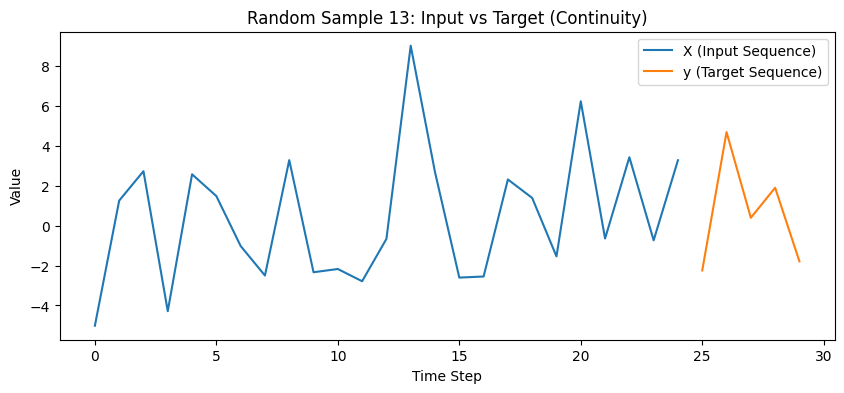

In [11]:
# Plot a random sample from X and y
idx = np.random.randint(len(X))
plt.figure(figsize=(10, 4))
plt.plot(range(X.shape[1]), X[idx], label='X (Input Sequence)')
plt.plot(range(X.shape[1], X.shape[1] + y.shape[1]), y[idx], label='y (Target Sequence)')
plt.title(f'Random Sample {idx}: Input vs Target (Continuity)')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

In [12]:
# Train/test split
X_train, y_train = X[:800], y[:800]
X_test, y_test = X[800:], y[800:]

In [13]:
# Convert to tensors and create DataLoader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

Epoch 1/4, Loss: 1.392814
Epoch 2/4, Loss: 1.037533
Epoch 2/4, Loss: 1.037533
Epoch 3/4, Loss: 1.023398
Epoch 3/4, Loss: 1.023398
Epoch 4/4, Loss: 1.009096
Epoch 4/4, Loss: 1.009096


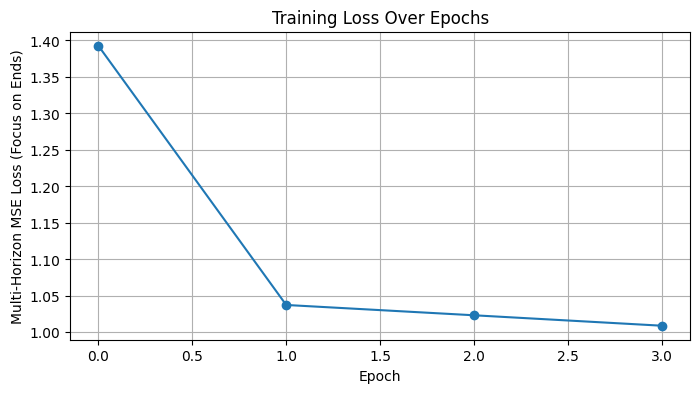

In [14]:
# Initialize the Recursive Transformer model
model = RecursiveTimeSeriesTransformer(seq_length=SEQ_LENGTH, forecast_steps=FORECAST_STEPS).to(device)

# Multi-horizon MSE loss function with custom weights
def multi_horizon_mse_loss(pred, target, weights=None):
    # pred, target: (batch_size, forecast_steps)
    losses = (pred - target) ** 2  # (batch_size, forecast_steps)
    if weights is not None:
        losses = losses * weights
    return losses.mean()

# Create custom weights to focus on both beginning and end
def create_focus_weights(steps):
    # Higher weights at both ends, lower in the middle
    x = np.linspace(-1, 1, steps)
    weights = 1.0 - np.abs(x)  # triangle shape
    weights = 0.5 + weights  # ensure minimum weight is 0.5
    weights = weights / weights.sum() * steps  # normalize to mean 1
    return torch.tensor(weights, dtype=torch.float32).unsqueeze(0)  # shape: (1, steps)

focus_weights = create_focus_weights(FORECAST_STEPS).to(device)

criterion = lambda pred, target: multi_horizon_mse_loss(pred, target, weights=focus_weights)
optimizer = optim.Adam(model.parameters(), lr=LR)

# Training loop
train_losses = []
for epoch in range(1, EPOCHS + 1):
    model.train()
    epoch_loss = 0.0
    for batch_X, batch_y in train_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()
        output = model(batch_X)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * batch_X.size(0)

    avg_loss = epoch_loss / len(train_loader.dataset)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch}/{EPOCHS}, Loss: {avg_loss:.6f}")

# Plot training loss
plt.figure(figsize=(8, 4))
plt.plot(train_losses, marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Multi-Horizon MSE Loss (Focus on Ends)')
plt.grid(True)
plt.show()

In [15]:
# # Training loop with teacher forcing
# train_losses = []
# for epoch in range(1, EPOCHS + 1):
#     model.train()
#     epoch_loss = 0.0
#     for batch_X, batch_y in train_loader:
#         batch_X = batch_X.to(device)
#         batch_y = batch_y.to(device)
#         optimizer.zero_grad()
#         # Teacher forcing: feed ground truth for each step
#         output = torch.zeros_like(batch_y)
#         prev = batch_X[:, -1]  # last value in input sequence
#         for t in range(FORECAST_STEPS):
#             if t == 0:
#                 inp_seq = batch_X
#             else:
#                 # Concatenate previous ground truth value to sequence
#                 inp_seq = torch.cat([batch_X, batch_y[:, :t]], dim=1)
#                 inp_seq = inp_seq[:, -SEQ_LENGTH:]
#             out_step = model(inp_seq)[:, t].unsqueeze(1)
#             output[:, t] = out_step.squeeze(1)
#         loss = criterion(output, batch_y)
#         loss.backward()
#         optimizer.step()
#         epoch_loss += loss.item() * batch_X.size(0)
#     avg_loss = epoch_loss / len(train_loader.dataset)
#     train_losses.append(avg_loss)
#     print(f"Epoch {epoch}/{EPOCHS}, Loss: {avg_loss:.6f}")

# # Plot training loss
# plt.figure(figsize=(8, 4))
# plt.plot(train_losses, marker='o')
# plt.title('Training Loss Over Epochs')
# plt.xlabel('Epoch')
# plt.ylabel('MSE Loss')
# plt.grid(True)
# plt.show()

Test Loss: 0.984089


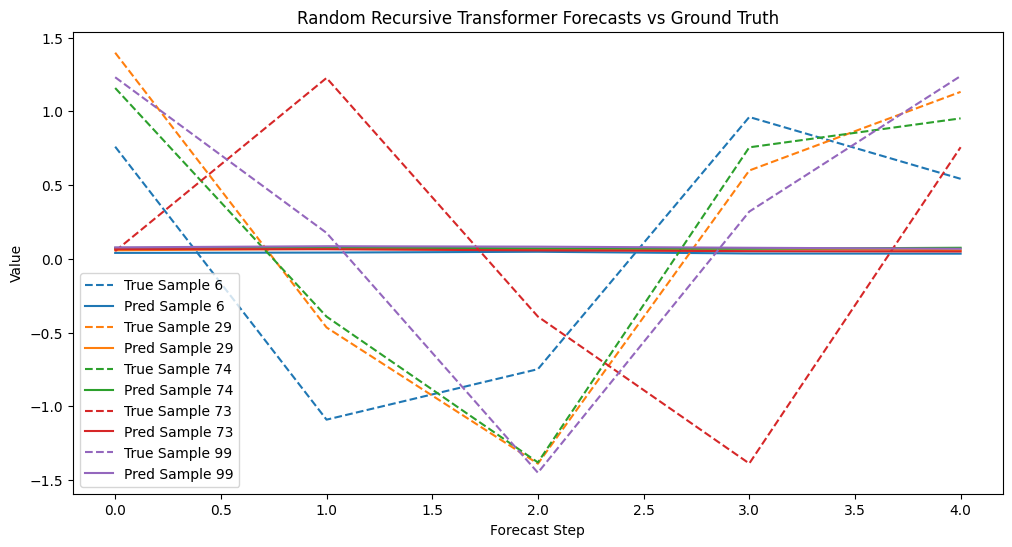

In [16]:
# Evaluate the model on the test set
model.eval()
test_loss = 0.0
predictions = []
ground_truth = []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        output = model(batch_X)
        loss = criterion(output, batch_y)
        test_loss += loss.item() * batch_X.size(0)
        predictions.append(output.cpu().numpy())
        ground_truth.append(batch_y.cpu().numpy())

avg_test_loss = test_loss / len(test_loader.dataset)
print(f"Test Loss: {avg_test_loss:.6f}")

# Concatenate all predictions and ground truth
predictions = np.concatenate(predictions, axis=0)
ground_truth = np.concatenate(ground_truth, axis=0)

# predictions = inverse_transform_predictions(predictions)
# ground_truth = inverse_transform_predictions(ground_truth)

# Choose 5 random indices from the test set
num_samples = min(5, len(predictions))
random_indices = np.random.choice(len(predictions), num_samples, replace=False)
colors = plt.cm.tab10.colors  # 10 distinct colors from matplotlib's tab10 colormap
plt.figure(figsize=(12, 6))
for idx, i in enumerate(random_indices):
    plt.plot(range(FORECAST_STEPS), ground_truth[i], label=f'True Sample {i+1}', linestyle='--', color=colors[idx % 10])
    plt.plot(range(FORECAST_STEPS), predictions[i], label=f'Pred Sample {i+1}', color=colors[idx % 10])
plt.title('Random Recursive Transformer Forecasts vs Ground Truth')
plt.xlabel('Forecast Step')
plt.ylabel('Value')
plt.legend()
plt.show()

ValueError: x and y must have same first dimension, but have shapes (6,) and (5,)

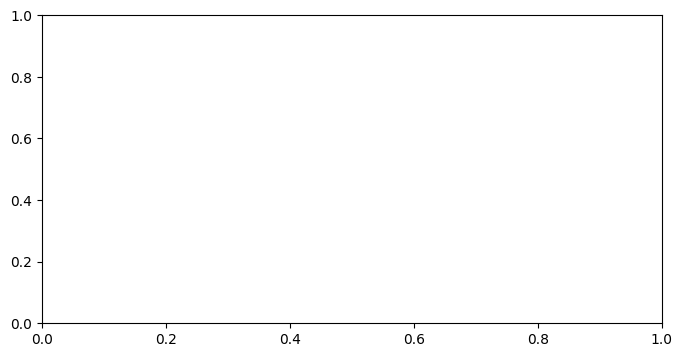

In [17]:
# Plot a separate figure for each true vs predicted sample in the test set (first 5 samples)
# for i in range(min(5, len(predictions))):
#     plt.figure(figsize=(8, 4))
#     plt.plot(range(FORECAST_STEPS), ground_truth[i], label='True', linestyle='--', color='blue')
#     plt.plot(range(FORECAST_STEPS), predictions[i], label='Predicted', color='orange')
#     plt.title(f'Sample {i+1}: True vs Predicted Forecast')
#     plt.xlabel('Forecast Step')
#     plt.ylabel('Value')
#     plt.legend()
#     plt.grid(True)
#     plt.show()

# Plot random samples from the test set
for idx, i in enumerate(random_indices):
    plt.figure(figsize=(8, 4))
    plt.plot(range(FORECAST_STEPS_LOGRET), ground_truth[i], label=f'True Sample {i+1}', linestyle='--', color=colors[idx % len(colors)])
    plt.plot(range(FORECAST_STEPS_LOGRET), predictions[i], label=f'Pred Sample {i+1}', color=colors[idx % len(colors)])
    plt.title(f'Random Test Sample {i+1}: True vs Predicted')
    plt.xlabel('Forecast Step')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()